# Neural Network from scratch
For this first assignment, you are asked to code a simple neural network from the scratch, using only numpy arrays.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# Fix random seed 
np.random.seed(12)

### Activation Functions

In [2]:
def relu(x):
    # Relu activation function 
    return np.maximum(0,x)

def relu_derivative(x):
    # Relu derivative function 
    x[x<=0] = 0
    x[x>0]  = 1
    return x
    
def sigmoid(x):
    # Sigmoid activation function 
    return 1/(1+np.exp(-x))

def clip(x):
    # Clipping threshold e
    e = 0.0000000001
    return np.maximum(x, e)

### Binary Cross Entropy Loss
$L_{B C E}=-\frac{1}{n} \sum_{i=1}^n\left(Y_i \cdot \log \hat{Y}_i+\left(1-Y_i\right) \cdot \log \left(1-\hat{Y}_i\right)\right)$ 

In [3]:
def binary_cross_entropy_loss(y, y_hat):   
    ## Clipping (>0) to avoid NaNs in log 
    y_hat     = clip(y_hat) 
    n         = len(y) 
    l_bce     = -1/n * (np.sum(np.multiply(y, np.log(y_hat)) + np.multiply((1.0 - y), np.log(clip(1.0 - y_hat)))))
    return l_bce

### Accuracy

In [4]:
def accuracy(y, y_hat):
    # Calculates the accuracy between the predicted labels and the truth labels
    # Fraction of predictions our model got right 
    acc = sum(y == y_hat) / len(y)
    return acc[0]

### NN class

In [5]:
class NeuralNetwork():
        
    def __init__(self, layers=[3,3,1]):
        # Params dictionary holding weights and bias for our NN layers
        self.parameters    = {}
        self.layers        = layers     
        
        # Loss x iteration tracking
        self.loss          = []
        
    def initialize_weights(self):
        # Weights initialization using random normal distribution
        # First layer
        self.parameters["W1"] = np.random.randn(self.layers[0], self.layers[1]) 
        self.parameters['b1'] = np.random.randn(self.layers[1])
        # Second layer
        self.parameters['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
        self.parameters['b2'] = np.random.randn(self.layers[2])
        
    def fit(self, x, y, learning_rate=0.001, iterations=1000):
        # Trains the neural network using the specified data (x) and labels (y)
        # Reset weights and bias
        self.initialize_weights() 
        
        # Train a number of iterations
        for i in range(iterations):
            # Propagate x
            y_hat = self.forward_propagation(x)
            # Compute BCE loss
            loss  = binary_cross_entropy_loss(y,y_hat)
            self.loss.append(loss)
            # Backpropagate
            self.back_propagation(x,y,y_hat,learning_rate)
    
    def forward_propagation(self,x):
        # Forward propagation
        Z1 = x.dot(self.parameters['W1'])  + self.parameters['b1']
        A1 = relu(Z1)
        Z2 = A1.dot(self.parameters['W2']) + self.parameters['b2']
        y_hat = sigmoid(Z2)
        
        # save calculated parameters     
        self.parameters['Z1'] = Z1
        self.parameters['Z2'] = Z2
        self.parameters['A1'] = A1

        return y_hat
    
    def back_propagation(self,x,y,y_hat,learning_rate):
        # Computes the derivatives, update weights and bias
        y_inv     = 1 - y
        y_hat_inv = 1 - y_hat

        dl_wrt_y_hat = np.divide(y_inv, clip(y_hat_inv)) - np.divide(y, clip(y_hat))
        dl_wrt_sig   = y_hat * (y_hat_inv)
        dl_wrt_z2    = dl_wrt_y_hat * dl_wrt_sig

        dl_wrt_A1    = dl_wrt_z2.dot(self.parameters['W2'].T)
        dl_wrt_w2    = self.parameters['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2    = np.sum(dl_wrt_z2, axis=0, keepdims=True)

        dl_wrt_z1    = dl_wrt_A1 * relu_derivative(self.parameters['Z1'])
        dl_wrt_w1    = x.T.dot(dl_wrt_z1)
        dl_wrt_b1    = np.sum(dl_wrt_z1, axis=0, keepdims=True)

        # Update the weights and bias
        self.parameters['W1'] = self.parameters['W1'] - learning_rate * dl_wrt_w1
        self.parameters['W2'] = self.parameters['W2'] - learning_rate * dl_wrt_w2
        self.parameters['b1'] = self.parameters['b1'] - learning_rate * dl_wrt_b1
        self.parameters['b2'] = self.parameters['b2'] - learning_rate * dl_wrt_b2
        
    def predict(self, x):
        # Predicts on test data
        Z1 = x.dot(self.parameters['W1'])  + self.parameters['b1']
        A1 = relu(Z1)
        Z2 = A1.dot(self.parameters['W2']) + self.parameters['b2']
        pred = sigmoid(Z2)
        return np.round(pred) 

    def plot_loss(self):
        # Plots the loss curve
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("Loss (BCE)")
        plt.title("Loss curve")
        plt.show()  

### Load dataset
We will use the Haberman’s Survival Dataset. The dataset contains cases from a study that was conducted between 1958 and 1970 at the University of Chicago's Billings Hospital on the survival of patients who had undergone surgery for breast cancer. There are 306 items (patients). There are three predictor variables (age, year of operation, number of detected nodes). The variable to predict is encoded as 1 (survived) or 2 (died). See https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival

In [6]:
import pandas as pd

headers =  ['age', 'year','nodes','y']
haberman_df = pd.read_csv('haberman_data/haberman.data', sep=',', names=headers)

In [7]:
haberman_df

,age,year,nodes,y
0,age,year,nodes,y
1,30,64,1,0
2,30,62,3,0
3,30,65,0,0
4,31,59,2,0
...,...,...,...,...
302,75,62,1,0
303,76,67,0,0
304,77,65,3,0
305,78,65,1,1


In [8]:
# Convert pandas dataframe into numpy arrays
x       = haberman_df.drop(columns=['y']).values[1:]
y_label = haberman_df['y'].values[1:].reshape(x.shape[0], 1).astype(float)

In [9]:
# Split data into train and test set
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y_label, test_size=0.2, random_state=2)

In [10]:
# Standardize the dataset
# Standardize features by removing the mean and scaling to unit variance.
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing   import StandardScaler

sc = StandardScaler()
sc.fit(xtrain)
xtrain = sc.transform(xtrain)
xtest  = sc.transform(xtest)

print("Shape of train set is {}".format(xtrain.shape))
print("Shape of test set is {}".format(xtest.shape))
print("Shape of train label is {}".format(ytrain.shape))
print("Shape of test labels is {}".format(ytest.shape))

Shape of train set is (244, 3)
Shape of test set is (62, 3)
Shape of train label is (244, 1)
Shape of test labels is (62, 1)


In [11]:
# Create and train the Neural Network model
nn = NeuralNetwork(layers=[3,5,1])
nn.fit(xtrain, ytrain, learning_rate=0.0001, iterations=1000) 

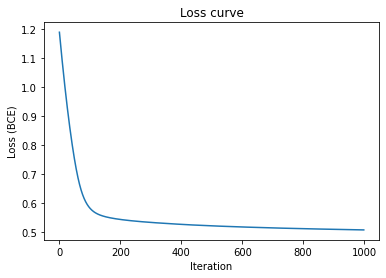

In [12]:
nn.plot_loss()

In [13]:
# Compare the training vs. testing data performance
train_pred = nn.predict(xtrain)
test_pred  = nn.predict(xtest)

print("Train accuracy is {0:.2f}".format(accuracy(ytrain, train_pred)))
print("Test accuracy is {0:.2f}".format(accuracy(ytest, test_pred)))

Train accuracy is 0.77
Test accuracy is 0.66
